In [1]:
import tensorflow as tf
import importlib
from model.model1D import Unet,Unet_Model
import model.model1D
importlib.reload(model.model1D)
try: 
    del unet
except:
    pass
import numpy as np


In [2]:
unet = Unet(n_classes=5,n_filters=8)
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
unet.model((8640,2)).summary()
 

5
4
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8640, 2)]    0           []                               
                                                                                                  
 downsampling_block (Downsampli  ((None, 4320, 8),   256         ['input_1[0][0]']                
 ngBlock)                        (None, 8640, 8))                                                 
                                                                                                  
 downsampling_block_1 (Downsamp  ((None, 2160, 16),  1184        ['downsampling_block[0][0]']     
 lingBlock)                      (None, 4320, 16))                                                
                                                                                          

In [3]:
import importlib
import dataloader.dataloader
import configs.config
from dataloader.dataloader import Series,TrainSerie,Dataset
importlib.reload(dataloader.dataloader)
importlib.reload(configs.config)
try: 
    del series
except:
    pass

from configs.config import CFG
from utils import config
config = config.Config.from_json(CFG)

In [4]:
series = Series(config.data,config.paths)
series.createSeries()
ds = Dataset(series)
ds.split_dataset()


In [5]:
X_train = ds.X_train
y_train = ds.y_train
X_test = ds.X_test
y_test = ds.y_test

X_train

array([[[-1.56172417e+00, -3.70847879e-01],
        [-1.56165690e+00, -3.71777134e-01],
        [-1.56375655e+00, -3.70847879e-01],
        ...,
        [-1.19942599e+00, -1.93381893e-03],
        [-2.62084872e-01,  1.75900357e+00],
        [-2.31553425e-01,  1.50624633e+00]],

       [[ 3.36417009e-01,  6.11374191e-01],
        [ 4.49894341e-01, -3.91040013e-02],
        [ 7.00752374e-01,  5.89072081e-01],
        ...,
        [ 1.27060144e+00, -3.71777134e-01],
        [ 1.27060144e+00, -3.71777134e-01],
        [ 1.18594749e+00, -3.67130861e-01]],

       [[ 2.24039952e-01,  1.03325576e+00],
        [ 1.22344958e-02,  1.84914127e+00],
        [ 5.81264365e-01,  8.24173485e-01],
        ...,
        [-1.02560647e+00, -8.43860085e-03],
        [-6.05411700e-01,  1.25070133e+00],
        [ 3.38002559e-01,  8.46357523e+00]],

       ...,

       [[-1.04832308e+00,  2.06658683e+00],
        [-1.41417433e+00, -3.18809624e-01],
        [-9.25308423e-01,  1.21724816e+00],
        ...,
     

In [6]:

history = unet.fit(X_train,y_train,epochs = 100)



Epoch 1/100
5
4
5
4
8/8 [==============================] - 6s 224ms/step - loss: 1.5304 - accuracy: 0.4810
Epoch 2/100
8/8 [==============================] - 2s 237ms/step - loss: 1.3412 - accuracy: 0.6409
Epoch 3/100
8/8 [==============================] - 2s 247ms/step - loss: 1.1975 - accuracy: 0.6035
Epoch 4/100
8/8 [==============================] - 2s 241ms/step - loss: 1.0726 - accuracy: 0.5706
Epoch 5/100
8/8 [==============================] - 2s 242ms/step - loss: 1.0320 - accuracy: 0.5707
Epoch 6/100
8/8 [==============================] - 2s 238ms/step - loss: 1.0047 - accuracy: 0.6009
Epoch 7/100
8/8 [==============================] - 2s 251ms/step - loss: 0.8725 - accuracy: 0.7246
Epoch 8/100
8/8 [==============================] - 2s 261ms/step - loss: 0.7699 - accuracy: 0.8038
Epoch 9/100
8/8 [==============================] - 2s 265ms/step - loss: 0.7414 - accuracy: 0.8408
Epoch 10/100
8/8 [==============================] - 2s 272ms/step - loss: 0.7517 - accuracy: 0.8830
E

In [7]:
def accuracy(real,pred):
    comp = real == pred
    return np.sum(comp)/(comp.shape[0]*comp.shape[1])


def predict(model,X):
    pred = model.predict(X)
    return np.argmax(pred,axis = -1,keepdims=True)

y_train_pred = predict(unet,X_train)
print("train accuracy : " + str(accuracy(y_train,y_train_pred)))


y_test_pred = predict(unet,X_test)
print("test accuracy : " +  str(accuracy(y_test,y_test_pred)))

5
4
8/8 [==============================] - 1s 53ms/step
train accuracy : 0.9626998258942704
2/2 [==============================] - 0s 59ms/step
test accuracy : 0.9596672944130571


In [9]:
test_serie_1 = TrainSerie()
serie = self.createSerie(serie_id)
serie.create_segmentation_mask(self.valid_steps)
serie.create_slices(self.steps_window,["series_id","step","timestamp"])


(59, 4320, 1)

In [90]:
#test_mask = series.series[series.series_ids[3]].mask_slices
test_mask = series.series["05e1944c3818"].mask_slices 
test_mask.shape

(92, 4320, 3)

In [81]:
test_mask[4,...,-1] 

array([0., 0., 0., ..., 1., 1., 1.])

In [82]:
np.max(test_mask[6,...,-1] == -1)

False

In [97]:
from time import time

In [123]:
def create(mask_slices):
    
    slices_len = mask_slices.shape[0]
    slices_with_zero = np.zeros(shape = (slices_len,),dtype=bool)
    for i in range(slices_len):
        slices_with_zero[i] = 1-np.max(mask_slices[i,...,-1] == -1)
    return mask_slices[slices_with_zero]

start_time = time()
slices_without_zero = create(test_mask)
print(time()-start_time)
slices_without_zero.shape

0.003017425537109375


(25, 4320, 3)

In [121]:
def create(mask_slices):
    
    slices_len = mask_slices.shape[0]
    slices_with_zero = np.zeros(shape = (slices_len,),dtype=bool)
    for i in range(slices_len):
        #slices_with_zero[i] = 1-np.max(mask_slices[i,...,-1] == -1)
        slices_with_zero[i] = 1-(-1 in  mask_slices[i,...,-1])
    return mask_slices[slices_with_zero]

start_time = time()
slices_without_zero = create(test_mask)
print(time()-start_time)
slices_without_zero.shape


0.002997875213623047


(25, 4320, 3)

In [124]:
def get_correct_slices(mask_slices):
    correct_slices = mask_slices.copy()
    deleted_indexes = []
    for i in range(correct_slices.shape[0]):
        if -1 in  correct_slices[i,...,-1]:
            deleted_indexes.append(i)
    return np.delete(correct_slices,deleted_indexes,axis = 0)

start_time = time()
slices_without_zero = get_correct_slices(test_mask)
print(time()-start_time)
slices_without_zero.shape

0.00500035285949707


(25, 4320, 3)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\DEV\Projekty\PythonProjects\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\pawel.dubel\AppData\Local\Temp\ipykernel_13352\2435840814.py", line 2, in <module>
    ds.split_dataset()
  File "d:\DEV\Projekty\PythonProjects\Kaggle\Detect-sleep-state\dataloader\dataloader.py", line 267, in split_dataset
  File "d:\DEV\Projekty\PythonProjects\Kaggle\Detect-sleep-state\dataloader\dataloader.py", line 275, in _fit_transform
ValueError: operands could not be broadcast together with shapes (234,4320,2) (234,2) 

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\DEV\Projekty\PythonProjects\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "d:\DEV\Projekty\PythonProjects\venv\lib\site-packages

In [150]:
np.max(test_mask[3,:,2] == 0.0)

False

In [165]:
count = 0
for i in range(test_mask.shape[0]):
    if np.max(test_mask[i,...,-1]) == 0.0:
        count+=1

count

45

In [118]:
type(series.series[series.series_ids[1]].mask_slices)

numpy.ndarray

In [138]:
ds.X_train.reshape(-1,ds.X_train.shape[-1]).shape

(1010880, 2)

In [162]:
class Normalizer:
    epsilon = 0.000001
    def __init__(self):
        self.mean = None 
        self.std = None
        

    def fit_transform(self,x):
        axis = tuple([i for i in range(len(x.shape)-1)])
        self.mean = x.mean(axis = axis)
        self.std = x.std(axis = axis)
        return (x-self.mean)/(self.__class__.epsilon+self.std)
    
    def transform(self,x):
        return (x-self.mean)/(self.__class__.epsilon+self.std)


    



X_train = ds.X_train
y_train = ds.y_train
X_test = ds.X_test
y_test = ds.y_test

ds_normalizer = Normalizer()
X_train_norm = ds_normalizer.fit_transform(X_train)
X_test_norm = ds_normalizer.transform(X_test)

print(f'{np.max(X_train)} min : {np.min(X_train)}')
print(f'{np.max(X_train_norm)} min : {np.min(X_train_norm)}')


89.5192 min : -90.0
43.88813629813631 min : -2.08555098924907


In [158]:
test_arr = np.array([[[50,30],
          [60,30],
          [70,30],
          [40,30],
          [20,30],
          [10,30],
          [90,50]],
          [[231,30],
          [60,30],
          [70,30],
          [40,30],
          [20,30],
          [10,30],
          [90,30]],])

ds_normalizer2 = Normalizer()
test_arr_norm = ds_normalizer2.fit_transform(test_arr)

assert test_arr_norm

[61.5        31.42857143]
[53.65864329  5.15078754]


array([[[-0.21431775, -0.27735004],
        [-0.02795449, -0.27735004],
        [ 0.15840877, -0.27735004],
        [-0.40068101, -0.27735004],
        [-0.77340754, -0.27735004],
        [-0.9597708 , -0.27735004],
        [ 0.5311353 ,  3.60555058]],

       [[ 3.1588573 , -0.27735004],
        [-0.02795449, -0.27735004],
        [ 0.15840877, -0.27735004],
        [-0.40068101, -0.27735004],
        [-0.77340754, -0.27735004],
        [-0.9597708 , -0.27735004],
        [ 0.5311353 , -0.27735004]]])

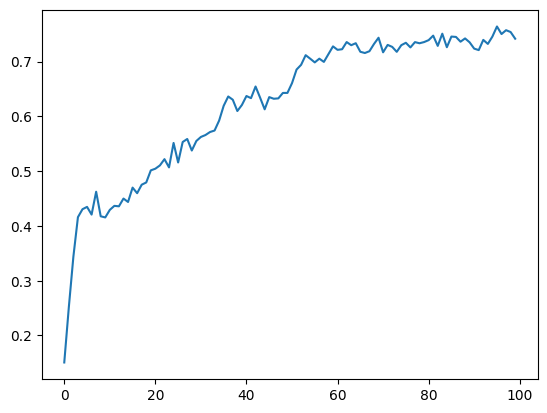

In [93]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"])

9/9 [==============================] - 1s 95ms/step
train accuracy : 0.7811392552624568
3/3 [==============================] - 0s 66ms/step
test accuracy : 0.7384507275132275


In [167]:
from IPython.display import FileLink
import pandas as pd

# import os
# os.chdir(r'kaggle/working')'
filename = 'train_' +'.csv'
pd.DataFrame(test_mask).to_csv(filename)

FileLink(filename)



ValueError: Must pass 2-d input. shape=(51, 8640, 3)